In [4]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [5]:
# globally refresh
df = common.load_reports()

In [7]:
trace = 'wc400m.tr'

filter_idx = (
    (df.trace_file == trace) 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 80000000)
)
df1 = df[filter_idx].copy()

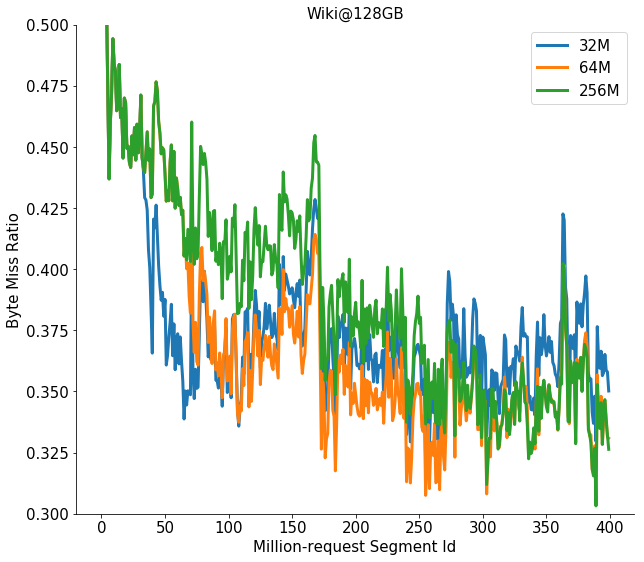

In [95]:
fig, ax = plt.subplots(figsize=(10, 9))

plt.plot(1-np.array(json.loads(df1[
    (df1.version == 'memory_window') 
    & (df1.memory_window == str(32*2**20))
].segment_byte_miss_rate.iloc[0])), 
        label='32M',
)

plt.plot(1-np.array(json.loads(df1[
    (df1.version == 'forward_window') 
    & (df1.forget_window == str(64*2**20))
].segment_byte_hit_rate.iloc[0])), 
        label='64M',        
)

plt.plot(1-np.array(json.loads(df1[
    (df1.version == 'forward_window') 
    & (df1.forget_window == str(256*2**20))
].segment_byte_hit_rate.iloc[0])), 
        label='256M',        
)
plt.legend()
plt.ylim([0.3, 0.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Million-request Segment Id')
plt.ylabel('Byte Miss Ratio')
plt.title(f'Wiki@128GB')

plt.show()

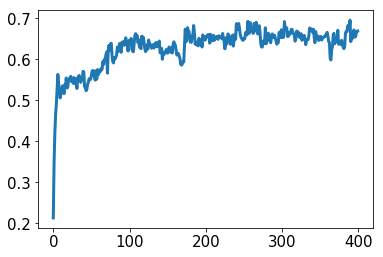

In [42]:
df1[(df1.version == 'forward_window') & (df1.forget_window == str(64*2**20))]

,batch_size,byte_hit_rate,cache_size,cache_type,cutoff,epsilon,feature_overhead,forget_window,k,label,...,sample_size,sample_type,segment_byte_hit_rate,segment_object_hit_rate,simulation_time,trace_file,training_sample_interval,uni_size,version,window
5388,100000,0.646988,1.374390e+11,GDBT,NaN,NaN,721682756,67108864,NaN,cache_type: GDBT batch_size: 100000 forget_win...,...,NaN,NaN,"[0.21328255998544526,0.3444574681348515,0.4184...","[0.593117,0.720289,0.773213,0.802989,0.819178,...",21811,wc400m.tr,64,0.0,forward_window,NaN


In [322]:
# implementation
df2 = df1[df1.version == 'implementation']
for l, grp in df2.groupby('cache_type'):
    print(l)
    print(1-grp.object_hit_rate)
    print((1-grp.byte_hit_rate)*10855007819035/1024.**3 + \
          334*(1-grp.object_hit_rate)*320e6/1024.**3 )

FIFO
17081    0.184177
Name: object_hit_rate, dtype: float64
17081    5188.216992
dtype: float64
GDBT
17080    0.090587
Name: object_hit_rate, dtype: float64
17080    3791.067008
dtype: float64


In [299]:
# implementation
1-df1[df1.cache_type == 'LFO'].byte_hit_rate

17242    0.528404
Name: byte_hit_rate, dtype: float64

In [297]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)
df_r['byte_miss_rate'] = 1-df_r['byte_hit_rate']
df_r[['cache_type', 'byte_miss_rate']].round(3)

,cache_type,byte_miss_rate
12004,Inf,0.118
12031,Belady,0.265
13026,GDBT,0.358
12692,Adaptive-TinyLFU,0.375
17238,LFU,0.379
17161,LRUK,0.379
17024,LeCaR,0.387
12737,LFUDA,0.402
12696,S4LRU,0.445
12016,LRU,0.453


In [306]:
trace = 'traceHK.tr'

filter_idx = (
    (df.trace_file == trace) 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [307]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)
df_r['byte_miss_rate'] = 1-df_r['byte_hit_rate']
df_r[['cache_type', 'byte_miss_rate']].round(3)

,cache_type,byte_miss_rate
12044,Inf,0.083
12068,Belady,0.243
13839,GDBT,0.322
13609,LFUDA,0.337
13565,Adaptive-TinyLFU,0.339
13567,S4LRU,0.343
13747,LeCaR,0.350
12060,LRU,0.350
16204,FIFO,0.367
13617,Hyperbolic,0.371


In [310]:
trace = 'traceUS.tr'

filter_idx = (
    (df.trace_file == trace) 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 100000000)
)

df1 = df[filter_idx].copy()

In [311]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)
df_r['byte_miss_rate'] = 1-df_r['byte_hit_rate']
df_r[['cache_type', 'byte_miss_rate']].round(3)

,cache_type,byte_miss_rate
13687,Inf,0.065
13844,Belady,0.090
16694,GDBT,0.109
15591,LFUDA,0.115
15512,Adaptive-TinyLFU,0.116
15570,S4LRU,0.120
13736,LRU,0.122
17074,FIFO,0.131
15554,Hyperbolic,0.133
15631,LHD,0.164


In [172]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]
df_r = df_r.groupby('cache_type').first().reset_index().sort_values('byte_hit_rate', ascending=False)

In [175]:
dfs.append(df_r[['trace_file', 'cache_type', 'segment_byte_hit_rate']].copy())

In [176]:
df = pd.concat(dfs).reset_index()

In [177]:
df

,index,trace_file,cache_type,segment_byte_hit_rate
0,7858,traceHK.tr,GDBT,0.394228\t0.333180\t0.522524\t0.630804\t0.7004...
1,7382,traceHK.tr,Belady,0.498017\t0.540547\t0.719880\t0.801108\t0.8418...
2,7448,traceHK.tr,LR,0.463725\t0.384974\t0.585486\t0.706187\t0.7555...
3,7397,traceHK.tr,LFUDA,0.473313\t0.422246\t0.620747\t0.736672\t0.7877...
4,7432,traceHK.tr,Adaptive-TinyLFU,NaN
5,7413,traceHK.tr,S4LRU,0.435828\t0.383660\t0.605902\t0.726435\t0.7832...
6,7374,traceHK.tr,LRU,0.472792\t0.414381\t0.612118\t0.729869\t0.7811...
7,7409,traceHK.tr,Hyperbolic,0.462664\t0.385042\t0.585134\t0.703918\t0.7569...
8,7389,traceHK.tr,LRUK,0.473031\t0.421564\t0.620011\t0.736813\t0.7866...
9,7467,traceHK.tr,LeCaR,0.473102\t0.419397\t0.620209\t0.738718\t0.7883...


In [178]:
df.loc[23].segment_byte_hit_rate

'0.213283\t0.344457\t0.418455\t0.463934\t0.485527\t0.494645\t0.509900\t0.501031\t0.493905\t0.481128\t0.495457\t0.491004\t0.493208\t0.493227\t0.480251\t0.486919\t0.475427\t0.517481\t0.499969\t0.494349\t0.514763\t0.522640\t0.531437\t0.533499\t0.522635\t0.531211\t0.522411\t0.518803\t0.509926\t0.529668\t0.514510\t0.503338\t0.525829\t0.533597\t0.531334\t0.526329\t0.526745\t0.543904\t0.541261\t0.549776\t0.564887\t0.496710\t0.504376\t0.499482\t0.515346\t0.522594\t0.527169\t0.517615\t0.514269\t0.525372\t0.529158\t0.552216\t0.551649\t0.552023\t0.544118\t0.524006\t0.534780\t0.533906\t0.559189\t0.552655\t0.533556\t0.545816\t0.535967\t0.543147\t0.556899\t0.574976\t0.573596\t0.569740\t0.560094\t0.561412\t0.562250\t0.502819\t0.557712\t0.553400\t0.541327\t0.561672\t0.561192\t0.543500\t0.517874\t0.516541\t0.526049\t0.523417\t0.536819\t0.540712\t0.546941\t0.550000\t0.556514\t0.550265\t0.531514\t0.535014\t0.556633\t0.558006\t0.570574\t0.554943\t0.560516\t0.577603\t0.558778\t0.542679\t0.535106\t0.564520\

In [179]:
len(df.loc[28].segment_byte_hit_rate.split())

400

In [180]:
with open('/data/zhenyus/segment_hit_rate.json', 'w') as f:
    f.write(pd.concat(dfs).reset_index().to_json())

In [181]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [182]:
df_r[['cache_type', 'object_hit_rate']].round(3)

,cache_type,object_hit_rate
7674,Inf,0.975
7763,GDSF,0.950
7769,GDWheel,0.948
7776,LHD,0.947
8496,GDBT,0.945
7767,AdaptSize,0.923
7686,Belady,0.919
7786,BeladySample,0.914
7720,LeCaR,0.870
7701,LRUK,0.866


In [183]:
plt.plot(np.array(df1.loc[5813].segment_object_hit_rate.split()).astype(float), label='gdbt')
plt.plot(np.array(df1.loc[4060].segment_object_hit_rate.split()).astype(float), label='gdsf')
plt.legend()

KeyError: 'the label [5813] is not in the [index]'

In [ ]:
# df_gdbt = [float(i) for i in df1.loc[3838].segment_byte_hit_rate.split('\t')[:-1]]
# df_lruk = [float(i) for i in df1.loc[3690].segment_byte_hit_rate.split('\t')[:-1]]
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [ ]:
trace = 'memc_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
#     & ((df.cache_type == 'Belady') | (df.cache_type == 'BeladySample'))
    & (df.cache_size == 1000000000)
    & (df.n_warmup == 20000000)
)

df1 = df[filter_idx].copy()

In [ ]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate']].round(4)

In [ ]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

In [ ]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'object_hit_rate']].round(3)

In [ ]:
# df_gdbt = [float(i) for i in df.loc[3844].segment_byte_hit_rate.split('\t')[:-1]]
# df_lruk = [float(i) for i in df.loc[3735].segment_byte_hit_rate.split('\t')[:-1]]
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [81]:
trace = 'msr_rehash_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & ((df.cache_type == 'Belady') | (df.cache_type == 'BeladySample'))
#         & (df.cache_type == 'GDBT')
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 100000000)
)

df1 = df[filter_idx].copy()

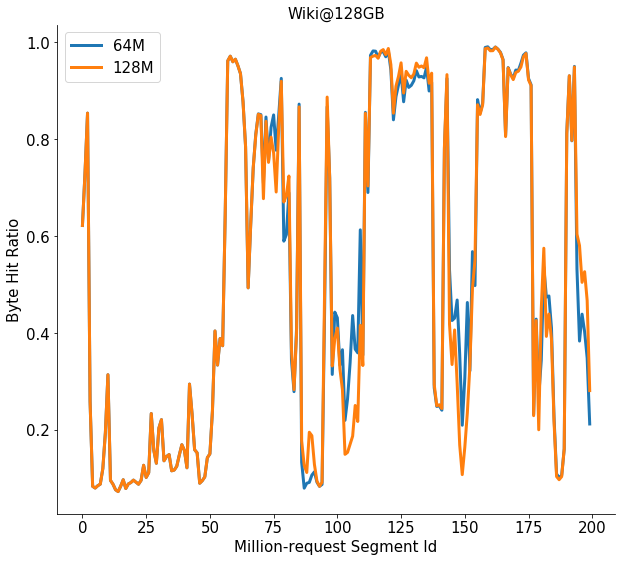

In [85]:
fig, ax = plt.subplots(figsize=(10, 9))

# plt.plot(json.loads(df1[
#     (df1.version == 'forward_window') 
#     & (df1.forget_window == str(32*2**20))
# ].segment_byte_hit_rate.iloc[0]), 
#         label='32M'
# )

plt.plot(json.loads(df1[
    (df1.version == 'forward_window') 
    & (df1.forget_window == str(64*2**20))
].segment_byte_hit_rate.iloc[0]), 
        label='64M',        
)

plt.plot(json.loads(df1[
    (df1.version == 'forward_window') 
    & (df1.forget_window == str(128*2**20))
].segment_byte_hit_rate.iloc[0]), 
        label='128M',        
)
plt.legend()
# plt.ylim([0.5, 0.7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Million-request Segment Id')
plt.ylabel('Byte Hit Ratio')
plt.title(f'Wiki@128GB')

plt.show()

In [224]:
df1[df1.cache_type == 'GDBT'][['byte_hit_rate', 'forget_window', 'objective']]

,byte_hit_rate,forget_window,objective
9872,0.475291,5000000,object_hit_rate
9873,0.460671,1000000,object_hit_rate
9874,0.450980,500000,object_hit_rate
9875,0.475291,5000000,byte_hit_rate
9876,0.460671,1000000,byte_hit_rate
9877,0.450980,500000,byte_hit_rate
9878,0.469624,2000000,byte_hit_rate
9879,0.469624,2000000,object_hit_rate
10102,0.475206,10000000,object_hit_rate
10107,0.475643,10000000,byte_hit_rate


In [225]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)

df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
9806,Inf,0.876
9848,BeladyTruncate,0.708
9863,Belady,0.708
10080,Adaptive-TinyLFU,0.631
10029,LHD,0.582
10048,AdaptSize,0.552
10064,LeCaR,0.530
9978,S4LRU,0.518
10043,Hyperbolic,0.515
10116,GDBT,0.498


In [218]:
trace = 'msr_rehash_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & ((df.cache_type == 'Belady') | (df.cache_type == 'BeladySample'))
#         & (df.cache_type == 'GDBT')
    & (df.cache_size == 614400000000)
    & (df.n_warmup == 100000000)
)

df1 = df[filter_idx].copy()

In [222]:
df1[df1.cache_type == 'GDBT'][['byte_hit_rate', 'forget_window', 'objective']]

,byte_hit_rate,forget_window,objective
9890,0.450980,500000,object_hit_rate
9891,0.475291,5000000,object_hit_rate
9892,0.479880,10000000,object_hit_rate
9893,0.475291,5000000,byte_hit_rate
9894,0.479880,10000000,byte_hit_rate
9896,0.450980,500000,byte_hit_rate
9897,0.460671,1000000,byte_hit_rate
9898,0.460671,1000000,object_hit_rate
9900,0.469624,2000000,object_hit_rate
9970,0.511034,20000000,byte_hit_rate


In [219]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)

df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
9802,Inf,0.876
9851,BeladyTruncate,0.876
9865,Belady,0.876
10011,LHD,0.781
9999,GDWheel,0.772
9995,LeCaR,0.754
9958,LFUDA,0.745
9982,LRUK,0.745
9813,LRU,0.743
10094,GDSF,0.743


In [ ]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate', 'ohr_size_penalty_factor']].round(4)

In [ ]:
df1[df1.version == 'hashed_pow']

In [ ]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

In [ ]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'object_hit_rate']].round(4)

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [ ]:
trace = 'anonymous_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & (df.cache_type == 'GDBT') 
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
    & (df.cache_size == 4000000000)
#     & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [ ]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate']].round(4)

In [ ]:
df1[df1.version == 'hashed_pow']

In [ ]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

In [ ]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [ ]:
df_r[['cache_type', 'object_hit_rate']].round(3)

In [ ]:
# df_gdbt = [float(i) for i in df1.loc[4057].segment_byte_hit_rate.split('\t')[:-1]]
# df_lruk = [float(i) for i in df1.loc[4022].segment_byte_hit_rate.split('\t')[:-1]]
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [ ]:
trace = 'caida_cache_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & (df.cache_type == 'GDBT') 
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
    & (df.cache_size == 2000000)
#     & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [ ]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate']].round(4)

In [ ]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False).drop_duplicates('cache_type')

In [ ]:
df_r[['cache_type', 'byte_hit_rate']].round(5)

In [ ]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False).drop_duplicates('cache_type')

In [ ]:
df_r[['cache_type', 'object_hit_rate']].round(3)

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [191]:
# df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [192]:
# df_r = df_r[df_r.cache_type.isin(
# {'Adaptive-TinyLFU',
#  'Hyperbolic',
#  'LFUDA',
#  'LR',
#  'LRU',
#  'LRUK',
#  'LeCaR',
#  'S4LRU',
#  'GDBT',
#  'Belady'})]

In [193]:
# dfs.append(df_r[['trace_file', 'cache_type', 'segment_byte_hit_rate']].copy())